# Step by Step Semantic Deduplication on Text Data

GPU accelerated implementation of [SemDeDup: Data-efficient learning at web-scale through semantic deduplication](https://arxiv.org/abs/2303.09540)  

The tutorial here shows how to run Semantic Duplication on text data by executing three workflows sequentially. 

We also use an ID Generator to show how it works when running it separately.

1. Create ID generator.
2. Running embedding generation
3. Running K-Means + pairwise (without duplicate identification)
4. Run duplicate identification
5. Run removal

We also allow users to run these steps as a single workflow, which can be seen in the end to end tutorial in the same directory as this tutorial.

In [ ]:
import os

os.environ["LOGURU_LEVEL"] = "ERROR"

import pandas as pd

input_path = os.path.abspath("./input")
semantic_out_dir = os.path.abspath("./output/step_by_step")
output_path = os.path.join(semantic_out_dir, "output")
cache_path = os.path.join(semantic_out_dir, "cache")

input_filetype = "parquet"  # this can be either of jsonl or parquet (you'll need to change how input data is generated and embedding generation reader to be jsonl)
output_filetype = "parquet"  # this can be either of jsonl or parquet

## Generate Input Data

We generate input data if we don't have files in the path above
 - We load the [TinyStories](https://huggingface.co/datasets/roneneldan/TinyStories) dataset (just the train partition) which has 2,119,719 rows
 - We split into shards such that no shard has more than 10,000 rows
 - We create a new ID column which is UUID
 - We write out ~212 files

In [2]:
from nemo_curator.utils.file_utils import get_all_file_paths_under

if len(get_all_file_paths_under(input_path)) == 0:
    import os
    import uuid

    import numpy as np
    from datasets import load_dataset

    input_df = load_dataset("roneneldan/TinyStories", split="train").to_pandas()
    num_rows_per_file = 10_000

    os.makedirs(input_path, exist_ok=True)

    for i, start_idx in enumerate(range(0, len(input_df), num_rows_per_file)):
        end_idx = min(len(input_df), start_idx + num_rows_per_file)
        subset_df = input_df.iloc[start_idx:end_idx].copy()
        subset_df["id"] = [str(uuid.uuid4()) for _ in range(len(subset_df))]
        subset_df.to_parquet(os.path.join(input_path, f"part_{i}.parquet"), index=False)

    print(f"Created {len(os.listdir(input_path))} files")

# Running Semantic Deduplication Workflow by Workflow

Here we intentionally break it down into executing three workflows. 

We also use the ID Generator to show it works when running it separately.

1. Create ID Generator.
2. Running embedding generation
3. Running K-Means + pairwise (without duplicate identification)
4. Run duplicate identification
5. Run removal

Both steps 2 and 5 require the use of the ID Generator created in step 1.

You might want to do this separately if
1. You have a separate job that generates embeddings.
2. You want to use different machine for different parts of the workflow. 
3. Your cluster limits how long a job can run for. 



In [ ]:
from nemo_curator.core.client import RayClient

# Number of GPUs should be roughly 2x the memory of the embeddings
client = RayClient(num_cpus=64, num_gpus=4)
client.start()

## Create ID Generator

1. This creates a Ray Actor in the background.
2. When we read our dataset now, this actor in the background is used to assign monotonically increasing integer IDs to each row. 

In [4]:
from nemo_curator.stages.deduplication.id_generator import create_id_generator_actor

create_id_generator_actor()

2025-09-16 13:44:04,277	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:44:04,280	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...


2025-09-16 13:44:04,342	INFO usage_lib.py:447 -- Usage stats collection is disabled.
2025-09-16 13:44:04,343	INFO scripts.py:913 -- Local node IP: 127.0.1.1
2025-09-16 13:44:07,176	SUCC scripts.py:949 -- --------------------
2025-09-16 13:44:07,176	SUCC scripts.py:950 -- Ray runtime started.
2025-09-16 13:44:07,176	SUCC scripts.py:951 -- --------------------
2025-09-16 13:44:07,176	INFO scripts.py:953 -- Next steps
2025-09-16 13:44:07,176	INFO scripts.py:956 -- To add another node to this Ray cluster, run
2025-09-16 13:44:07,176	INFO scripts.py:959 --   ray start --address='127.0.1.1:6379'
2025-09-16 13:44:07,176	INFO scripts.py:968 -- To connect to this Ray cluster:
2025-09-16 13:44:07,176	INFO scripts.py:970 -- import ray
2025-09-16 13:44:07,176	INFO scripts.py:971 -- ray.init(_node_ip_address='127.0.1.1')
2025-09-16 13:44:07,177	INFO scripts.py:983 -- To submit a Ray job using the Ray Jobs CLI:
2025-09-16 13:44:07,177	INFO scripts.py:984 --   RAY_API_SERVER_ADDRESS='http://127.0.0.1

2025-09-16 13:44:07,377	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


## Run Embedding Generation

1.  We output the embeddings as Parquet files so that we can read more smartly during our K-Means step. This is the recommended file format before you run K-Means.


In [ ]:
from nemo_curator.pipeline import Pipeline
from nemo_curator.stages.text.embedders import EmbeddingCreatorStage
from nemo_curator.stages.text.io.reader import ParquetReader
from nemo_curator.stages.text.io.writer import ParquetWriter

embedding_output_path = os.path.join(cache_path, "embeddings")

embedding_pipeline = Pipeline(
    name="embedding_pipeline",
    stages=[
        # We specify _generate_ids=True to use the ID generator we created in step 1.
        ParquetReader(file_paths=input_path, files_per_partition=1, fields=["text"], _generate_ids=True),
        EmbeddingCreatorStage(
            model_identifier="sentence-transformers/all-MiniLM-L6-v2",
            text_field="text",
            max_seq_length=None,
            max_chars=None,
            embedding_pooling="mean_pooling",
            model_inference_batch_size=256,
        ),
        # We specify the fields out so that we also don't end up writing the `text` field, or the intermediate `input_ids` and `attention_mask` fields which are no longer needed.
        ParquetWriter(path=embedding_output_path, fields=["_curator_dedup_id", "embeddings"]),
    ],
)

embedding_out = embedding_pipeline.run()

2025-09-16 13:44:12,448	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:44:12,451	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:44:12,457	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-16 13:44:12,471	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:44:12,473	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:44:12,473	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.
Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 31215.36it/s]


### Save the ID Generator to disk and kill the actor

In [ ]:
from nemo_curator.stages.deduplication.id_generator import kill_id_generator_actor, write_id_generator_to_disk

id_generator_actor_path = os.path.join(output_path, "semantic_id_generator.json")
write_id_generator_to_disk(id_generator_actor_path)
kill_id_generator_actor()

2025-09-16 13:48:10,787	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:48:10,791	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:48:10,800	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


(KMeansReadFitWriteStage pid=2365182) 203520000
(KMeansReadFitWriteStage pid=2365188) 203520000
(KMeansReadFitWriteStage pid=2365179) 203412096
(KMeansReadFitWriteStage pid=2365184) 203520000


#### Embeddings Results

1. `_curator_dedup_id` : The ID field generated by our `IdGenerator` and `ParquetReader`, since in our `ParquetReader` we specified `_generate_ids=True`.
2. `embeddings` : The embedding generated by the model we used above.

In [7]:
embeddings_path = os.path.join(cache_path, "embeddings")

pd.read_parquet(os.path.join(embeddings_path, os.listdir(embeddings_path)[0])).head()

,_curator_dedup_id,embeddings
0,1949719,"[-0.12394736707210541, 0.010744917206466198, 0..."
1,1949720,"[-0.07273813337087631, 0.06685175746679306, 0...."
2,1949721,"[-0.04823765903711319, 0.11327654868364334, -0..."
3,1949722,"[-0.08059918135404587, 0.024182168766856194, -..."
4,1949723,"[-0.031761009246110916, 0.02613956294953823, 0..."


## Run Semantic Deduplication workflow (without specifying `eps`)

1. We intentionally don't specify `eps` so that we can show how to run `IdentifyDuplicates` as a separate stage.

In [ ]:
from nemo_curator.stages.deduplication.semantic import RankingStrategy, SemanticDeduplicationWorkflow

semantic_workflow_path = os.path.join(cache_path, "semantic_dedup")

workflow = SemanticDeduplicationWorkflow(
    input_path=embedding_output_path,
    output_path=semantic_workflow_path,
    n_clusters=100,
    # Since we use Id Generator in the embedding generation step, we need to specify the ID field as `_curator_dedup_id`
    id_field="_curator_dedup_id",
    embedding_field="embeddings",
    ranking_strategy=RankingStrategy(metadata_cols=["cosine_dist_to_cent"], ascending=True),
    # if eps is specified then it'll also run IdentifyDuplicates stage
    eps=None,
)
semantic_out = workflow.run()

2025-09-16 13:48:14,425	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:48:14,426	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:48:14,427	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.
2025-09-16 13:48:40,029	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:48:40,031	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:48:40,039	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-16 13:48:40,054	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:48:40,056	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:48:40,056	INFO worker.py:1789 -- Calling ray.init() again after it

#### K-Means Results

1. `_curator_dedup_id` : The IDs of the rows that belong to the cluster.
2. `embeddings` : These are later used for pairwise similarity.
3. `l2_dist_to_cent` / `cosine_dist_to_cent` : This represents how far (l2 distance or cosine distance) a sample is from our cluster's centroid.
    - These fields help us define how we want to prioritize ranking within our cluster. See `RankingStrategy`
    - If we had other `metadata_fields` provided they would be used here instead.


In [9]:
kmeans_path_first_centroid = os.path.join(semantic_workflow_path, "kmeans_results", "centroid=0")

pd.read_parquet(os.path.join(kmeans_path_first_centroid, os.listdir(kmeans_path_first_centroid)[0])).head()

,_curator_dedup_id,embeddings,l2_dist_to_cent,cosine_dist_to_cent
0,280260,"[-0.051341612, 0.023956891, 0.0818636, 0.01455...",0.564816,0.174425
1,280366,"[-0.029556809, 0.040268984, 0.13631389, -0.001...",0.677134,0.261470
2,280795,"[-0.08078232, 0.032830615, 0.10732673, -0.0177...",0.545988,0.161375
3,280814,"[-0.016866645, 0.03228915, 0.021343842, 0.0527...",0.599459,0.199594
4,281333,"[-0.04058464, 0.023736855, 0.09525293, 0.05758...",0.553146,0.166285


#### Pairwise Similarity Result

1. `id` : The identifier for the duplicate row.
2. `max_id` : The closest pair for the duplicate row.
3. `cosine_sim_score` : The cosine similarity between the two points.


In [10]:
pairwise_path = os.path.join(cache_path, "semantic_dedup", "pairwise_results")

pd.read_parquet(os.path.join(pairwise_path, "cluster_0.parquet")).head()

,id,max_id,cosine_sim_score
0,1806089,1806089,0.000000
1,1339989,1806089,0.932138
2,699085,1806089,0.936246
3,1220322,1806089,0.915550
4,1948996,1806089,0.928383


#### Investigate Results of Semantic Workflow

Depending on our dataset size we can read through all of the files and plot how much data is similar to one another.
Here we show how to read file by file and then perform a reduce. 

Based on the analysis here we can decide what our `eps` parameter should be, proceed to identify the duplicates, and finally perform removal

In [11]:
from collections import Counter
from functools import reduce

import numpy as np

pairwise_path = os.path.join(semantic_workflow_path, "pairwise_results")


def get_bins(df: pd.DataFrame, num_bins: int = 1_000) -> dict[float, int]:
    bins = np.linspace(0, 1.01, num_bins)

    return Counter(
        pd.cut(df["cosine_sim_score"], bins=bins, labels=bins[1:], retbins=False, include_lowest=True, right=True)
        .value_counts()
        .to_dict()
    )


similarity_across_dataset = reduce(
    lambda x, y: x + y,
    [
        get_bins(pd.read_parquet(os.path.join(pairwise_path, f), columns=["cosine_sim_score"]), num_bins=1000)
        for f in os.listdir(pairwise_path)
    ],
)

Looking at the graph below we see 20% of our dataset is above 0.9 cosine similarity. So for the purpose of this tutorial we can use 0.1 (1 - 0.9) as our `eps` parameter.

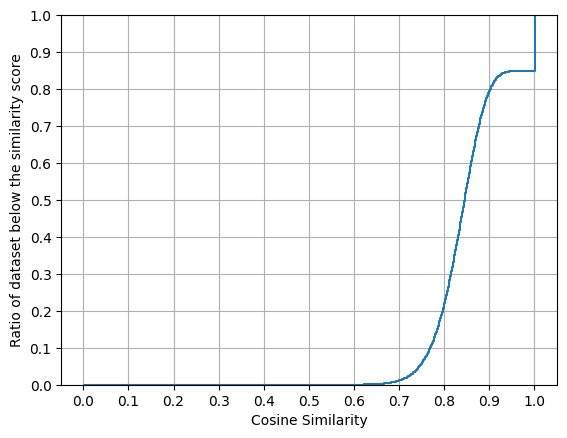

In [12]:
import matplotlib.pyplot as plt

plt.ecdf(x=similarity_across_dataset.keys(), weights=similarity_across_dataset.values())
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel("Cosine Similarity")
plt.ylabel("Ratio of dataset below the similarity score")
plt.grid()
plt.show()

## Identify Duplicates

We will create a simple pipeline that now identifies duplicates and writes them out.

In [13]:
from nemo_curator.pipeline import Pipeline
from nemo_curator.stages.deduplication.semantic import IdentifyDuplicatesStage
from nemo_curator.stages.file_partitioning import FilePartitioningStage
from nemo_curator.utils.file_utils import create_or_overwrite_dir

duplicates_output_path = os.path.join(output_path, "duplicates")
create_or_overwrite_dir(duplicates_output_path)

identify_duplicates_pipeline = Pipeline(
    name="identify_duplicates_pipeline",
    stages=[
        FilePartitioningStage(
            file_paths=pairwise_path,
            # we select files per partition to be 1, because IdentifyDuplicates has default batch_size of 10
            # this means it'll process 10 files at a time
            files_per_partition=1,
        ),
        IdentifyDuplicatesStage(
            output_path=duplicates_output_path,
            eps=0.1,
        ),
    ],
)

identify_duplicates_out = identify_duplicates_pipeline.run()

2025-09-16 13:49:55,497	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:49:55,499	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:49:55,506	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-16 13:49:55,520	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:49:55,522	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:49:55,522	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.


#### Looking at Duplicates

- `id` : This is a list of all IDs that are above our similarity threshold `eps`.

In [14]:
pd.read_parquet(os.path.join(duplicates_output_path, os.listdir(duplicates_output_path)[0])).head()

,id
0,115
1,268
2,273
3,280
4,323


## Removing Duplicates

We offer a simple `TextDuplicatesRemovalWorkflow` that can remove duplicates from a given input dataset and list of duplicates to remove. 

### Notes
1. When running the removal workflow, we must specify the same input configuration as we did when we "generated IDs".
2. In this tutorial that happened at the embedding generation step.
3. Therefore it's required that we match the same arguments of filepath, filetype and `files_per_partition`/`blocksize`.
4. This is required because IDs are generated by hashing the filenames in each task. If the filenames (and their partitioning) do not match exactly between steps, the ID Generator will not be able to find the correct IDs and will error out.

### Performance
If you notice OOMs during this stage, you can try using `RayDataActor`.


### How `TextDuplicatesRemovalWorkflow` works
1. It starts the ID Generator using `create_id_generator(filepath=...)`
1. It runs a pipeline that does [`ParquetReader`, `TextDuplicatesRemovalStage`, `ParquetWriter`] (assuming input/output filetypes are Parquet)
1. It kills the ID Generator using `kill_id_generator_actor`


In [ ]:
from nemo_curator.stages.text.deduplication.removal_workflow import TextDuplicatesRemovalWorkflow

duplicates_output_path = os.path.join(output_path, "duplicates")

# The workflow starts from a new IdGenerator from the persisted id generator
# This helps it assign the same IDs back to the same file
# It is important the we read again the same dataset using the same file path and files_per_partition / blocksize arguments
id_generator_path = os.path.join(output_path, "semantic_id_generator.json")

removal_workflow = TextDuplicatesRemovalWorkflow(
    input_path=input_path,
    ids_to_remove_path=duplicates_output_path,
    output_path=os.path.join(output_path, "deduplicated"),
    # input args
    input_filetype=input_filetype,
    input_fields=["text"],
    input_files_per_partition=1,
    # output args
    output_filetype=output_filetype,
    output_fields=["text", "_curator_dedup_id"],
    # id args
    ids_to_remove_duplicate_id_field="id",  # this is the field that contains the IDs of the duplicates
    id_generator_path=id_generator_path,
)

removal_out = removal_workflow.run()

2025-09-16 13:50:29,842	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:50:29,845	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:50:29,852	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-16 13:50:30,361	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:50:30,364	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:50:30,371	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-16 13:50:30,385	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:50:30,387	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:50:30,387	INFO worker.py:1789 -- Calling ray.init() ag

### Looking at the Deduplicated Dataset

In [17]:
deduplicated_path = os.path.join(output_path, "deduplicated")

pd.read_parquet(os.path.join(deduplicated_path, os.listdir(deduplicated_path)[0])).head()

,text,_curator_dedup_id
0,"Once upon a time, there was a big dog named Ma...",1150000
1,"Once upon a time, there was a shy little girl ...",1150001
2,"Once upon a time, there was a little boy named...",1150002
5,"Once upon a time, there was a little bear who ...",1150005
6,"Once upon a time, there was a little girl name...",1150006


## Printing Statistics of the Dataset

In [18]:
number_of_input_rows = sum(task._stage_perf[1].num_items_processed for task in removal_out)
number_of_output_rows = sum([task._stage_perf[2].num_items_processed for task in removal_out])
number_of_removed_rows = sum([task._metadata.get("num_removed") for task in removal_out])

print(f"Number of input rows\t: {number_of_input_rows:,}")
print(f"Number of output rows\t: {number_of_output_rows:,}")
print(f"Number of removed rows\t: {number_of_removed_rows:,}")
print(f"Ratio of removed rows\t: {(number_of_removed_rows * 100 / number_of_input_rows):.2f}%")

Number of input rows	: 2,119,719
Number of output rows	: 1,684,623
Number of removed rows	: 435,096
Ratio of removed rows	: 20.53%


## Stop the Cluster

In [ ]:
client.stop()

: 

## Conclusion

We broke down the semantic deduplication process into distinct steps - embedding generation, K-means clustering with pairwise similarity computation, duplicate identification, and final removal.

We showed how to create, persist, and reuse the ID Generator across different workflow stages, enabling consistent ID assignment throughout the process.

By analyzing the cosine similarity distribution across our dataset, we determined an appropriate `eps` threshold of 0.1, which resulted in removing ~20% of our data.

This step-by-step approach provides users with fine-grained control over each stage of the deduplication process, making it suitable for production environments where different components may need to be optimized or scaled independently.